In [34]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
from scipy.sparse import hstack 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,  roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
import string
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from sklearn.metrics import rand_score
import copy
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arses\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
pip install nltk 

Note: you may need to restart the kernel to use updated packages.


<font size = '5'>Reading the Training and the Test Files

<font size='3'>For feature engineering, I chose to work with two columns from the dataset: 'review' and 'summary'. I initially explored additional columns, but after some experimentation, they did not improve the model’s overall performance. As a result, I focused on just the 'review' and 'summary' fields for preprocessing and feature extraction.

In [2]:
train= pd.read_csv('Training.csv')
review_train = train['reviewText']
summary_train= train['summary'].fillna('') #fillna replaces the nan values with empty spaces 
verified_train = train['verified'].astype(str)
votes_train = train['vote'].astype(str)

Test = pd.read_csv('Test.csv')
review_test = Test['reviewText']
summary_test = Test['summary'].fillna('')
verified_test = Test['verified'].astype(str)
votes_test = Test['vote'].astype(str)


I added additional steps for preprocessing the text data by converting all words to lowercase and removing punctuation. 

In [25]:

def remove_punctuation(text):
    lemamantizer = WordNetLemmatizer() 
    text = lemamantizer.lemmatize(text)
    text = text.lower()
    return text.translate(str.maketrans('', '', string.punctuation))

<font size = '5'>Vectorizing the training and testing datasets\
<font size ='3'> I used CountVectorizer for Bernoulli Naive Bayes and TfidfVectorizer for logistic regression and Multinomial Naive Bayes to align with each model’s assumptions. Since Bernoulli Naive Bayes models the presence or absence of features, CountVectorizer (with binary values) is a better fit and led to higher performance compared to Tfidf. On the other hand, logistic regression and MNB performed better with Tfidf, which captures term importance more effectively.

In [26]:
def vectorize(vectorizer1, vectorizer2): 
    global review_train,summary_train, review_test, summary_test
    
    vectorizer_review = copy.deepcopy(vectorizer1)
    vectorizer_summary = copy.deepcopy(vectorizer2)

    review_train_number = vectorizer_review.fit_transform(review_train)
    summary_train_number  = vectorizer_summary.fit_transform(summary_train)

    review_test_number = vectorizer_review.transform(review_test)
    summary_test_number = vectorizer_summary.transform(summary_test)

    combined_train = hstack((review_train_number, summary_train_number))
    combined_test = hstack((review_test_number, summary_test_number ))

    return combined_train, combined_test


In [27]:
Binary_Split = {'1' : train['overall'].replace({1:0, 2:1, 3:1, 4:1, 5:1}), 
          '2' : train['overall'].replace({1:0, 2:0, 3:1, 4:1, 5:1}) ,
          '3' : train['overall'].replace({1:0, 2:0, 3:0, 4:1, 5:1}),
          '4' : train['overall'].replace({1:0, 2:0, 3:0, 4:0, 5:1})}

<font size = '6'>Classifiers:<br>
<font size = '3'>

1. Logistic Regression:
It was the fastest and best-performing model out of the 6–7 I tested. I was also most familiar with it from class, which made implementation easier.

2. Multinomial Naive Bayes:
We briefly covered Naive Bayes in class, which encouraged me to try it. MNB was much faster than models like random forests and gave consistently strong results.

3. Bernoulli Naive Bayes:
Like MNB, it was extremely fast and produced reliable results, making it a good fit for quick experimentation.

Overall, these three models gave better average results and were easier to tune and debug due to their speed.

In [28]:
logistic_regression = LogisticRegression(solver = 'liblinear')
MNB = MultinomialNB()
BNB = BernoulliNB()

<font size = "6">Logistic Regression 

<font size = '3'>For all of my classification models, I performed hyperparameter tuning using GridSearchCV from the scikit-learn library. I selected hyperparameters that I was familiar with or had some conceptual understanding of after reviewing the documentation. For logistic regression, I chose relatively small values for 'C', which is the inverse of regularization strength. Lower 'C' values imply stronger regularization, which helps reduce the risk of overfitting. Although I experimented with feature scaling/ normalizing, I did not observe any significant performance improvements, so I removed it to simplify the overall training process. After tuning, the logistic regression model achieved performance well above the required threshold.

In [31]:
log_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation),
                        TfidfVectorizer( ngram_range =(1,2), max_features=3000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))
combined_train_log,  combined_test_log = log_vectors[0], log_vectors[1]

param_grid_log = {

    'max_iter':[500],
    'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2], 
    'class_weight':['balanced', None],
    'penalty':['l2' ]

}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_log, y_split, test_size= 0.2, stratify = y_split)


    gridlog = GridSearchCV(logistic_regression,param_grid = param_grid_log, scoring = 'f1_macro', cv = 5)
    gridlog.fit(X_train,y_train )

    
    Probabilities = gridlog.predict_proba(X_test)
    y_pred = gridlog.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for binary classification (Threshold: {name})')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridlog.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridlog.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for logistic regression with cutoff {name}  are {gridlog.best_params_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}")
    print("__________________________________________________________________________________________________________________", end="\n\n")


    test = gridlog.predict(combined_test_log)
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\arses/nltk_data'
    - 'c:\\Users\\arses\\.ai-navigator\\micromamba\\envs\\cpu\\nltk_data'
    - 'c:\\Users\\arses\\.ai-navigator\\micromamba\\envs\\cpu\\share\\nltk_data'
    - 'c:\\Users\\arses\\.ai-navigator\\micromamba\\envs\\cpu\\lib\\nltk_data'
    - 'C:\\Users\\arses\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


<font size = '5'> Multinomial NB \
<font size = '3'>For the Multinomial Naive Bayes (MNB) model, I just tune the hyperparameters 'alpha' and 'fit_prior', as MNB offers relatively fewer parameters to adjust compared to other models. Among these, the smoothing parameter 'alpha' is particularly important because it addresses the issue of sparse data and prevents zero probabilities for unseen features, which is common in text classification tasks. Given MNB's simplicity and computational efficiency, especially with high-dimensional data, I was able to experiment with a wide range of alpha values to better understand its impact on model performance. 

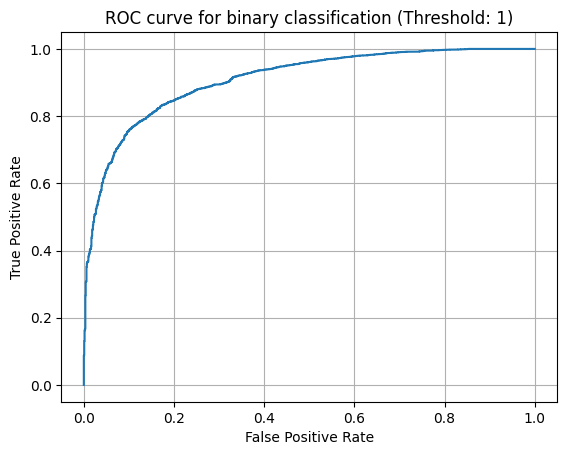

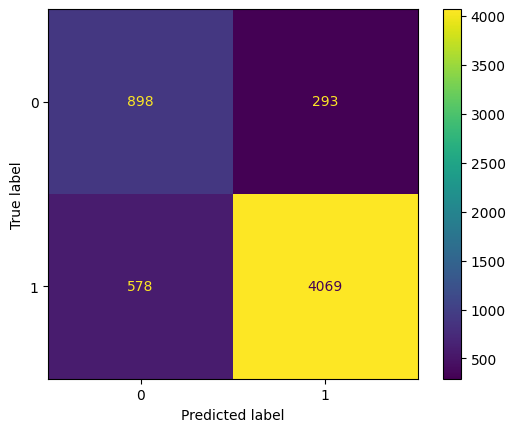

The best hyperparameters for Multinomial Naive Bayes with cutoff 1  are {'alpha': 2, 'fit_prior': False}
The AUC score for this model is: 0.908551457500727
The f1 macro score for this model is: 0.7883673631705128
The accuracy score for this model is: 0.8508050702295307

__________________________________________________________________________________________________________

(4500, 2)


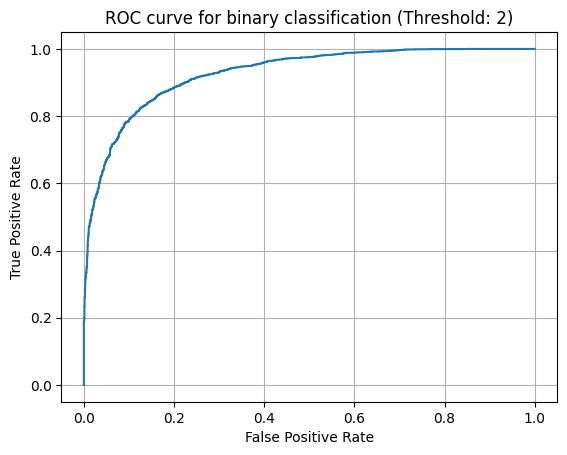

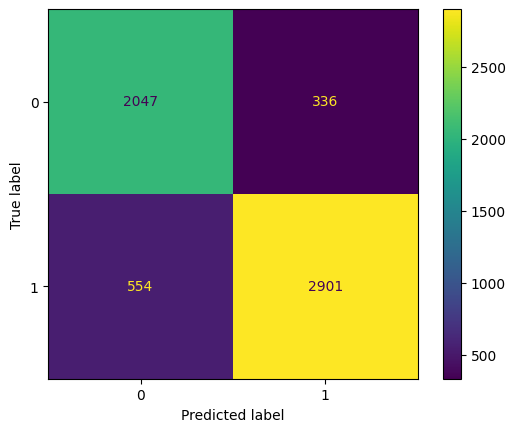

The best hyperparameters for Multinomial Naive Bayes with cutoff 2  are {'alpha': 2, 'fit_prior': False}
The AUC score for this model is: 0.9274691146222064
The f1 macro score for this model is: 0.8442169754931261
The accuracy score for this model is: 0.8475505310037684

__________________________________________________________________________________________________________

(4500, 2)


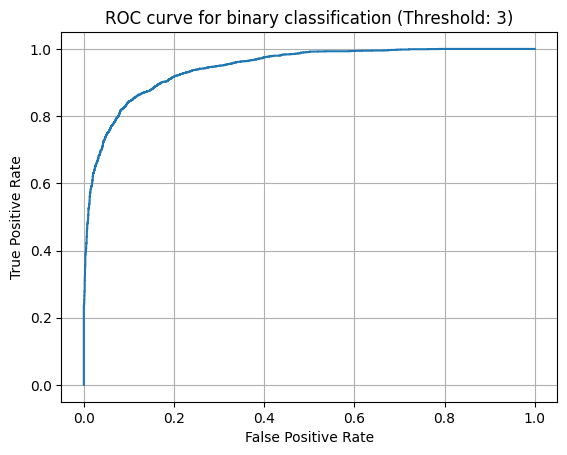

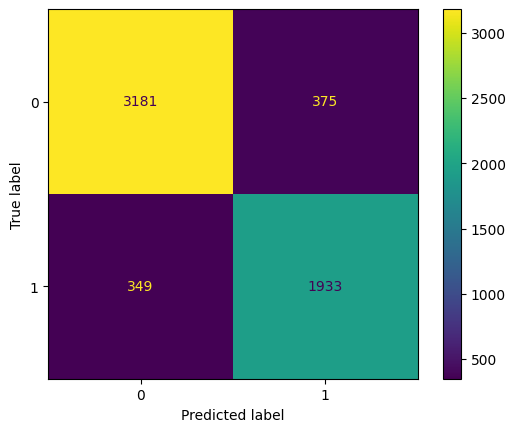

The best hyperparameters for Multinomial Naive Bayes with cutoff 3  are {'alpha': 1, 'fit_prior': False}
The AUC score for this model is: 0.9451380885671499
The f1 macro score for this model is: 0.8700462478716202
The accuracy score for this model is: 0.8759849263446385

__________________________________________________________________________________________________________

(4500, 2)


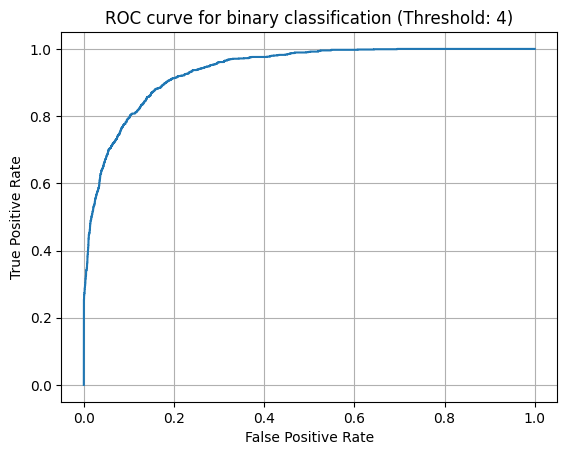

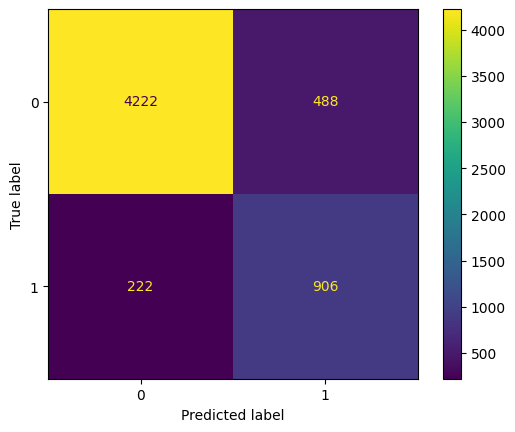

The best hyperparameters for Multinomial Naive Bayes with cutoff 4  are {'alpha': 0.1, 'fit_prior': False}
The AUC score for this model is: 0.9379864593214979
The f1 macro score for this model is: 0.8204578386190166
The accuracy score for this model is: 0.8783830078794107

__________________________________________________________________________________________________________

(4500, 2)


In [8]:
MNB_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation), 
                        TfidfVectorizer( ngram_range =(1,2), max_features=3000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))
combined_train_MNB,  combined_test_MNB = MNB_vectors[0], MNB_vectors[1]

param_grid_MNB = {

    'alpha':[0.1, 0.5, 0.8, 1, 2,3 ,4 , 5, 6 ],
    'fit_prior': [True, False]
}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_MNB, y_split, test_size= 0.2, stratify = y_split)
    gridMNB = GridSearchCV(MNB,param_grid = param_grid_MNB, scoring = 'f1_macro', cv = 5)
    gridMNB.fit(X_train,y_train )
    
    Probabilities = gridMNB.predict_proba(X_test)
    y_pred = gridMNB.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for binary classification (Threshold: {name})')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridMNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridMNB.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for Multinomial Naive Bayes with cutoff {name}  are {gridMNB.best_params_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    
    print(f"The accuracy score for this model is: {accuracy}", end="\n\n")
    print("__________________________________________________________________________________________________________", end = '\n\n')


    test = gridMNB.predict(combined_test_MNB)   
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    print(test_submission.shape)
    test_submission.head()
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


<font size = '6'> Bernoulli Naive Bayes Classifier\
<font size = '3'>  I tune the same hyperparameters for Bernoulli Naive Bayes (BNB) as I do for Multinomial Naive Bayes (MNB). However, since BNB and MNB make fundamentally different assumptions about the data, they produce different results. MNB assumes that features represent term frequencies, while BNB assumes binary (presence/absence) features. To stay consistent with BNB's underlying assumptions, I use CountVectorizer with binary=True instead of TfidfVectorizer, which encodes frequency-based weights that do not align with BNB’s Bernoulli distribution assumption.

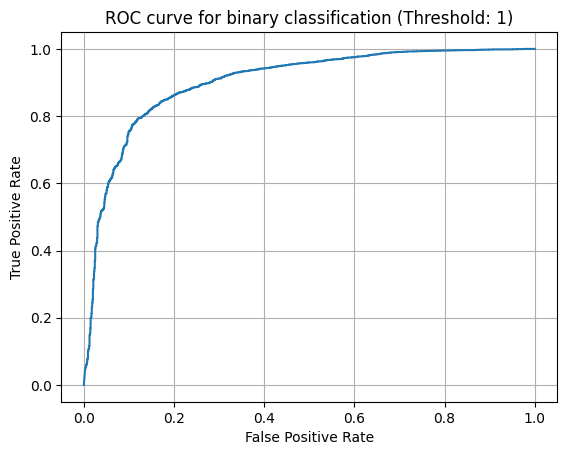

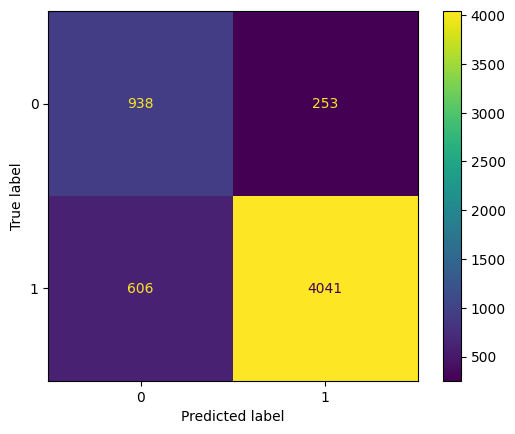

The best hyperparameters for Bernoulli Naive Bayes with cutoff 1  are {'alpha': 2, 'fit_prior': True}
The AUC score for this model is: 0.9020871875122524
The f1 macro score for this model is: 0.7949244764633152
The accuracy score for this model is: 0.8528605686879068

__________________________________________________________________________________________________________________________

(4500, 2)


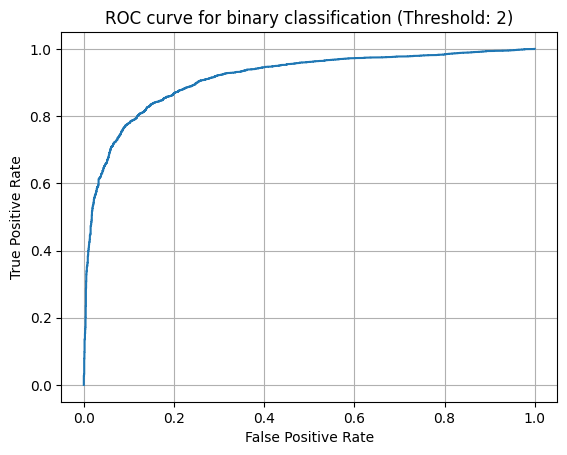

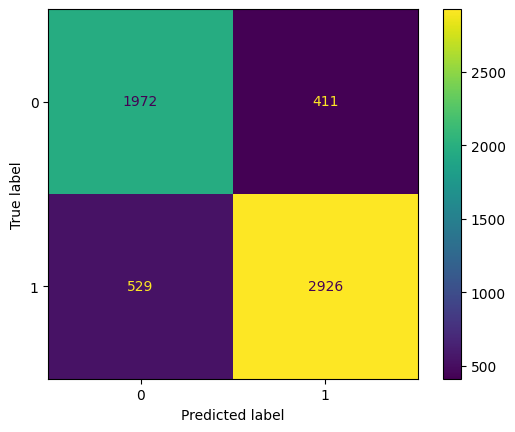

The best hyperparameters for Bernoulli Naive Bayes with cutoff 2  are {'alpha': 0.1, 'fit_prior': False}
The AUC score for this model is: 0.9140219584818416
The f1 macro score for this model is: 0.834568346052445
The accuracy score for this model is: 0.8389859540938678

__________________________________________________________________________________________________________________________

(4500, 2)


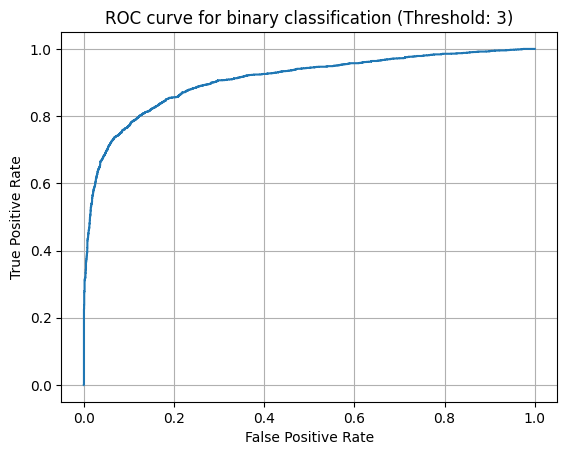

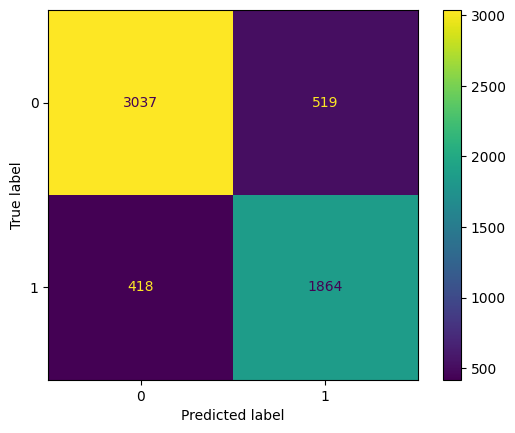

The best hyperparameters for Bernoulli Naive Bayes with cutoff 3  are {'alpha': 6, 'fit_prior': True}
The AUC score for this model is: 0.9085067738027051
The f1 macro score for this model is: 0.832747712483048
The accuracy score for this model is: 0.8394998287084618

__________________________________________________________________________________________________________________________

(4500, 2)


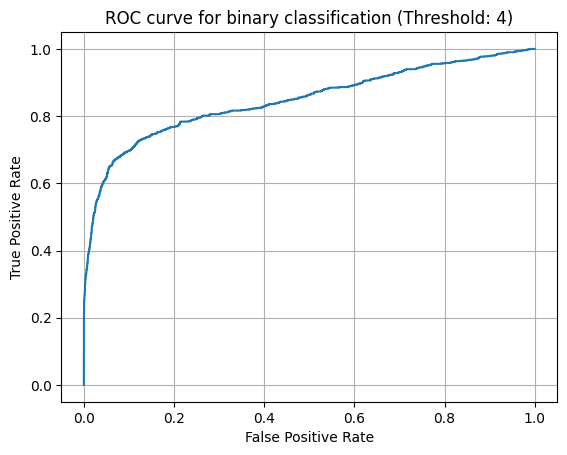

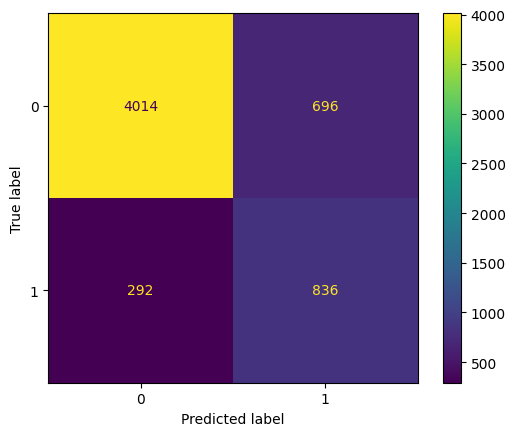

The best hyperparameters for Bernoulli Naive Bayes with cutoff 4  are {'alpha': 6, 'fit_prior': True}
The AUC score for this model is: 0.8474563701796389
The f1 macro score for this model is: 0.7594942324755989
The accuracy score for this model is: 0.8307639602603631

__________________________________________________________________________________________________________________________

(4500, 2)


In [9]:
BNB_vectors = vectorize(CountVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation, binary = True),
                        CountVectorizer( ngram_range =(1,2), max_features=3000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation, binary = True))

combined_train_BNB,  combined_test_BNB = BNB_vectors[0], BNB_vectors[1]

param_grid_BNB = {

    'alpha':[0.01, 0.1, 0.2, 0.5,0.6, 0.7, 0.8, 0.9, 1, 2, 4, 5, 6],
    'fit_prior': [True, False]
}

for name, y_split  in Binary_Split.items():

    X_train, X_test, y_train, y_test = train_test_split(combined_train_BNB, y_split, test_size= 0.2, stratify = y_split)


    gridBNB = GridSearchCV(BNB,param_grid = param_grid_BNB, scoring = 'f1_macro', cv = 5)
    gridBNB.fit(X_train,y_train )
    
    Probabilities = gridBNB.predict_proba(X_test)
    y_pred = gridBNB.predict(X_test)
    auc_score = float(roc_auc_score(y_test, Probabilities[:, 1]))
    macro_f1 = f1_score(y_test, y_pred, average  ='macro') 
    accuracy = accuracy_score(y_test,y_pred)

    #plotting the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, Probabilities[:, 1] )
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for binary classification (Threshold: {name})')
    plt.grid()

    #Displaying the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=gridBNB.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=gridBNB.classes_)
    disp.plot()
    plt.show()

    print(f"The best hyperparameters for Bernoulli Naive Bayes with cutoff {name}  are {gridBNB.best_params_}")
    print(f"The AUC score for this model is: {auc_score}")
    print(f"The f1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}", end="\n\n")

    print("__________________________________________________________________________________________________________________________", end = '\n\n')


    test = gridBNB.predict(combined_test_BNB)   
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, f'binary_split_{name}':test})
    print(test_submission.shape)
    test_submission.head()
    test_submission.to_csv(f'test_submission_part_{name}.csv', index= False)
    


<font size = '8'> Multiclass Classification

The best hyperparameters for Multinomial Naive Bayes are {'alpha': 4, 'fit_prior': False}


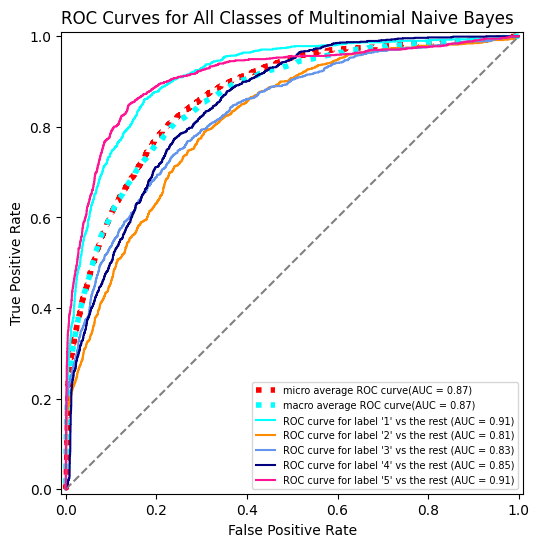

 The confusion matrix for Multinomial Naive Bayes :


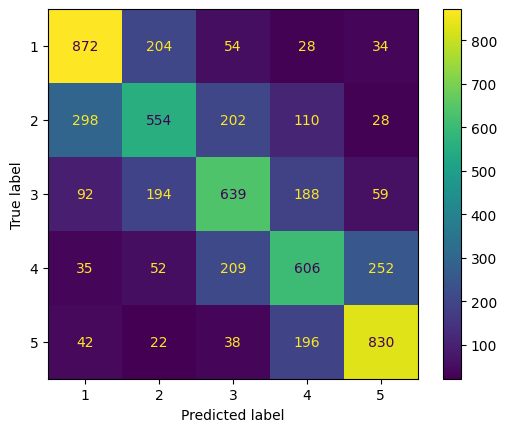

The average macro AUC score for this model is: 0.8633899112813183
The average micro AUC score for this model is: 0.8687777314486687
The average F1 macro score for this model is: 0.5968298059324757
The accuracy score for this model is: 0.5996916752312436
___________________________________________________________________________________________________________________________________________

The best hyperparameters for Bernoulli Naive Bayes are {'alpha': 0.01, 'fit_prior': True}


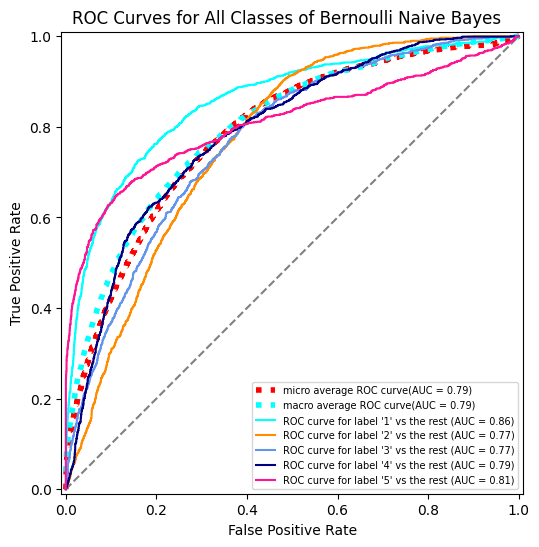

 The confusion matrix for Bernoulli Naive Bayes :


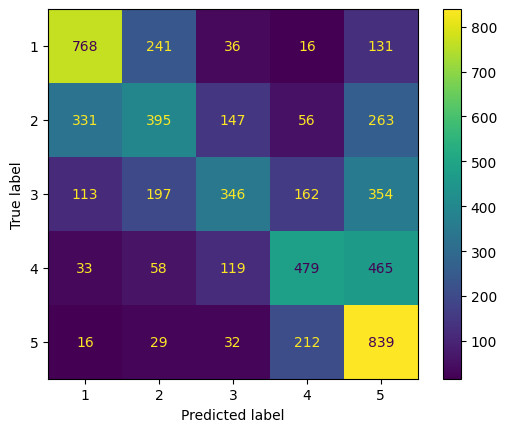

The average macro AUC score for this model is: 0.7991544375077699
The average micro AUC score for this model is: 0.7874755693903254
The average F1 macro score for this model is: 0.4724693178622955
The accuracy score for this model is: 0.4842411784857828
___________________________________________________________________________________________________________________________________________

The best hyperparameters for Logistic Regression are {'C': 0.5, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2'}


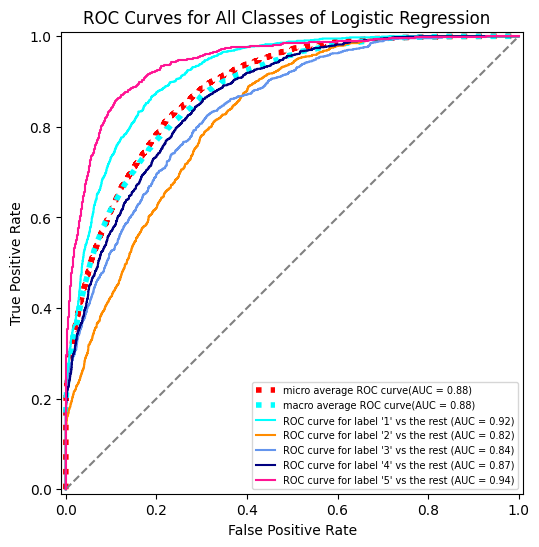

 The confusion matrix for Logistic Regression :


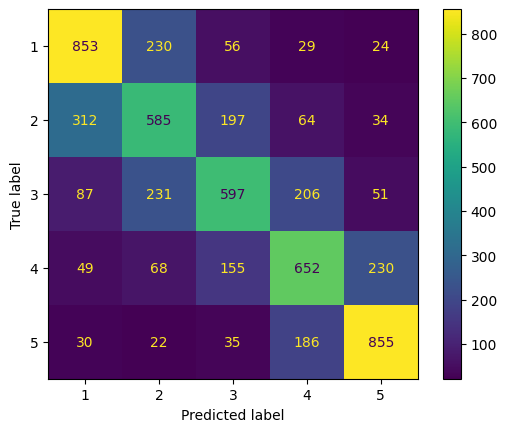

The average macro AUC score for this model is: 0.8779177308160908
The average micro AUC score for this model is: 0.8844024178689643
The average F1 macro score for this model is: 0.6048314688551185
The accuracy score for this model is: 0.6067146282973621
___________________________________________________________________________________________________________________________________________



In [10]:

multiclass_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation),
                               TfidfVectorizer( ngram_range =(1,2), max_features=3000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))
train_mcc_tfid,  test_mcc_tfid = multiclass_vectors[0], multiclass_vectors[1]


multiclass_vectors = vectorize(CountVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation, binary = True),
                               CountVectorizer( ngram_range =(1,2), max_features=3000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation, binary = True))
train_mcc_count,  test_mcc_count = multiclass_vectors[0], multiclass_vectors[1]


Y = train['overall'].copy()


param_grid_list = [ param_grid_MNB, param_grid_BNB, param_grid_log]
models = [ MNB,  BNB, logistic_regression]
model_names = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression' ]

# Logistic Regression','logreg',LogisticRegression(solver = 'liblinear'),param_grid_log,


for i, model  in enumerate(models):

    if model ==logistic_regression or model == param_grid_MNB:
        X_train, X_test, y_train, y_test = train_test_split(train_mcc_tfid, Y, test_size= 0.2, stratify = Y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(train_mcc_count, Y, test_size= 0.2, stratify = Y)
    
    grid = GridSearchCV(model, param_grid = param_grid_list[i], scoring = 'f1_macro',cv = 5)
    grid.fit(X_train,y_train)


    print(f"The best hyperparameters for {model_names[i]} are {grid.best_params_}")

    #predicting 
    Probabilities = grid.predict_proba(X_test)
    y_pred = grid.predict(X_test)



# Finding ROC, and AUC (average macro and micro) values
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_pred = label_binarizer.transform(y_pred)
    fpr, tpr, roc_auc = {}, {}, {}

    #Finding the average micro AUC score
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), Probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #Finding the average macro AUC score
    for j in range(5): 
        fpr[j], tpr[j], _ = roc_curve(y_onehot_test[:, j], Probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for k in range(5): 
        mean_tpr += np.interp(fpr_grid, fpr[k], tpr[k])
        
    mean_tpr /= 5
    
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    #Plotting the average(micro and macro) ROC  alonf with ROC curves for individual classes  
    fig, ax = plt.subplots(figsize = (6,6))
    
    #Micro ROC curve 
    plt.plot(
        fpr["micro"], 
        tpr["micro"], 
        label = f"micro average ROC curve(AUC = {roc_auc['micro']:.2f})",
        color = "red",
        linestyle = ":",
        linewidth = 4,
    )
    #Macro ROC curve 
    plt.plot(
        fpr["macro"], 
        tpr["macro"], 
        label = f"macro average ROC curve(AUC = {roc_auc['micro']:.2f})",
        color = "cyan",
        linestyle = ":",
        linewidth = 4,
    )
    plt.plot([0,1], [0, 1], linestyle ="--", color = 'grey')

    #plotting ROC curves individual classes 
    classes = [1,2,3,4,5]
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "navy", "deeppink"])
    for l, color in zip(classes, colors): 
        fpr[l], tpr[l], _ = roc_curve(y_onehot_test[:, l-1], Probabilities[:, l-1])
        display = RocCurveDisplay(fpr = fpr[l], tpr=tpr[l], estimator_name=f"ROC curve for label '{l}' vs the rest (AUC = {auc(fpr[l], tpr[l]):.2f})")
        display.plot(ax=ax, color=color) 
        plt.legend(fontsize = 7 )
    
    ax.set(
        xlabel ="False Positive Rate", 
        ylabel = "True Positive Rate",
        title = f"ROC Curves for All Classes of {model_names[i]}  "
    )
    plt.show()
    
    print(f" The confusion matrix for {model_names[i]} :")

    cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=grid.classes_)
    disp.plot()
    plt.show()

    macro_f1 = f1_score(y_test, y_pred, average = 'macro')
    accuracy = accuracy_score(y_test, y_pred)


    print(f"The average macro AUC score for this model is: {roc_auc["macro"]}")
    print(f"The average micro AUC score for this model is: {roc_auc["micro"]}")
    print(f"The average F1 macro score for this model is: {macro_f1}")
    print(f"The accuracy score for this model is: {accuracy}")


    # print(f"The f1 macro score for this model is: {macro_f1}")
    print("___________________________________________________________________________________________________________________________________________", end="\n\n")
    
    if model ==logistic_regression or model == param_grid_MNB:
        test = grid.predict(test_mcc_tfid)
    else: 
        test = grid.predict(test_mcc_count)
    test_ids = Test.index
    test_submission = pd.DataFrame({'id':test_ids, 'labels':test})
    test_submission.head()
    test_submission.to_csv(f'multiclass_model_{i+1}.csv', index= False)

<font size = '6'> Kaggle Scores for Classification Tasks

<font size = '3'>
- Threshold 1: 0.80557 <br>
- Threshold 2: 0.84623 <br>
- Threshold 3: 0.88311 <br>
- Threshold 4: 0.83166 <br>
- Multiclass : 0.61134
<br><br>
______________________________________________________________________________________________________________________________________________________________________

<font size = '6'> Clustering

<font size = '3'> Through experimentation, I found that CountVectorizer is not optimal for clustering, as it removes information about word frequency. The resulting feature space is a sparse matrix of 0s and 1s, which can lead to poor cluster separation. To address this, I reprocessed the data using TfidfVectorizer, which retains more information by assigning continuous values between 0 and 1 based on term importance. My assumption was that this would improve clustering performance, and the results confirmed it.

In [11]:
cluster_vectors = vectorize(TfidfVectorizer( ngram_range =(1,2), max_features=10000 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation), 
                        TfidfVectorizer( ngram_range =(1,2), max_features=2500 , max_df = 0.7, min_df = 6, preprocessor=remove_punctuation))

combined_test_cluster = cluster_vectors[1]

<font size = '4'> I use principle component analysis to significantly reduce the number of dimensions/ features, which helped reduce noise significantly, making the clustering  more efficient and accurate. 

In [12]:
Clustering_data = combined_test_cluster.copy()
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(Clustering_data)
category_numbers = Test['category'].nunique()
kmeans = KMeans(n_clusters = category_numbers, random_state = 0).fit_predict(X_reduced)
silhouette = silhouette_score(X_reduced, kmeans)
rand_ind = rand_score(Test['category'],kmeans )

print(f'The silhouette score is {silhouette}]')
print(f'The random index score is {rand_ind}')

The silhouette score is 0.7603991739750539]
The random index score is 0.40803457558469786
